In [1]:
using DifferentialEquations
using Plots
α = 1
β = 1
u₀ = 1 / 2
f(u, p, t) = α * u
g(u, p, t) = β * u
dt = 1 // 2^(4)
tspan = (0.0, 1.0)
prob = SDEProblem(f, g, u₀, (0.0, 1.0))

SDEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 1.0)
u0: 0.5

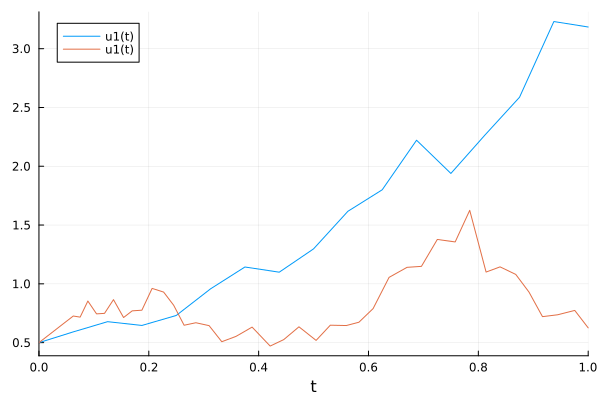

In [2]:
sol = solve(prob, EM(), dt = dt)
sol2 = solve(prob, SRIW1(), dt = dt)
plot(sol)
plot!(sol2)

In [3]:
ensembleprob = EnsembleProblem(prob)
sol = solve(ensembleprob, EnsembleThreads(), trajectories = 1000)

EnsembleSolution Solution of length 1000 with uType:
RODESolution{Float64, 1, Vector{Float64}, Nothing, Nothing, Vector{Float64}, NoiseProcess{Float64, 1, Float64, Float64, Float64, Vector{Float64}, typeof(DiffEqNoiseProcess.WHITE_NOISE_DIST), typeof(DiffEqNoiseProcess.WHITE_NOISE_BRIDGE), false, ResettableStacks.ResettableStack{Tuple{Float64, Float64, Float64}, false}, ResettableStacks.ResettableStack{Tuple{Float64, Float64, Float64}, false}, RSWM{Float64}, Nothing, RandomNumbers.Xorshifts.Xoroshiro128Plus}, SDEProblem{Float64, Tuple{Float64, Float64}, false, SciMLBase.NullParameters, Nothing, SDEFunction{false, SciMLBase.FullSpecialize, typeof(f), typeof(g), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, typeof(g), Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, Nothing}, SOSRI, StochasticDi

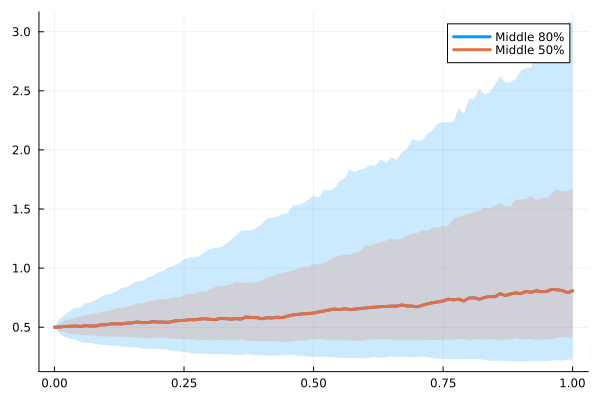

In [4]:
using DifferentialEquations.EnsembleAnalysis
summ = EnsembleSummary(sol, 0:0.01:1; quantiles = [0.1, 0.9])
plot(summ, labels = "Middle 80%")
summ = EnsembleSummary(sol, 0:0.01:1; quantiles = [0.25, 0.75])
plot!(summ, labels = "Middle 50%", legend = true)

Now try with the Cancitis model

In [5]:
function cancitis_rhs(du, u, p, t)
    # defines the right-hand side of the original cancitis model as defined in the PLOS One paper from 2017
    # for now only allows constant external inflammatory load I (last entry in p)
    rx, ry, ax, ay, Ax, Ay, dx0, dy0, dx1, dy1, dy0t, cxx, cxy, cyx, cyy, es, rs, ea, rm, I = p
    x0, x1, y0, y1, a, s = u
    phix = 1/(1+(cxx*x0 + cxy*y0)^2)
    phiy = 1/(1+(cyx*x0 + cyy*y0)^2)
    du[1] = (rx * phix * s - dx0 - ax - rm*s)*x0
    du[2] = ax*Ax*x0 - dx1*x1
    du[3] = (ry * phiy * s - dy0 - ay)*y0 + rm*s*x0
    du[4] = ay*Ay*y0 - dy1*y1
    du[5] = dx0*x0 + dx1*x1 + dy0*y0 + dy1*y1 - ea*s*a
    du[6] = rs*a - es*s + I
end

cancitis_rhs (generic function with 1 method)

In [17]:
using StaticArrays
u0 = SA[1.01e4, 3.84e10, 0, 0, 699, 3.61]
p = [8.7e-4, 1.5e-3, 1.1e-5, 1.1e-5, 4.7e13, 4.7e13, 2e-3, 2e-3, 129, 129, 2e-9, 7.5e-5, 7.5e-5, 7.5e-5, 7.5e-5, 2, 3e-4, 2e9, 2e-8, 7]
t_final = 365*80
prob = ODEProblem(cancitis_rhs, u0, (0, t_final), p)

LoadError: ArgumentError: Package StaticArrays not found in current path:
- Run `import Pkg; Pkg.add("StaticArrays")` to install the StaticArrays package.


In [14]:
@time cancitis_rhs(du, u0, p, 0)

  0.000029 seconds (1 allocation: 16 bytes)


-0.010299999999999976

In [15]:
@time sol = solve(prob, Rodas4())

  0.002166 seconds (657 allocations: 82.062 KiB)


retcode: Success
Interpolation: specialized 3rd order "free" stiffness-aware interpolation
t: 97-element Vector{Float64}:
     0.0
     1.5002196694380604e-8
     2.1805857851289805e-8
     3.1579744198458145e-8
     4.8850961944879225e-8
     8.827939513150988e-8
     2.1465238401695966e-7
     1.0803776595652518e-6
     9.737630415048172e-6
     6.540625827907834e-5
     0.00012107488614310852
     0.00020396685197294887
     0.00038514363978744433
     ⋮
 21209.719330634984
 21983.663105347547
 22759.758813667802
 23538.111428386106
 24319.21379137051
 25104.15884377015
 25894.856988575455
 26693.96063036564
 27503.9344526374
 28325.37148062351
 29156.573276832674
 29200.0
u: 97-element Vector{Vector{Float64}}:
 [10100.0, 3.84e10, 0.0, 0.0, 699.0, 3.61]
 [10099.999999997657, 3.8400004022085045e10, 1.0939901873271734e-11, 4.2425654319339216e-11, 686.963945217313, 3.6099999997878927]
 [10099.999999996595, 3.840000584614228e10, 1.5901267661884477e-11, 8.963240817886075e-11, 686.1973605

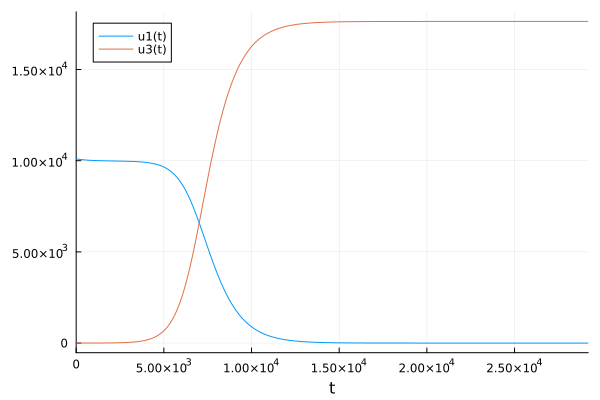

In [16]:
plot(sol, idxs=[1, 3])

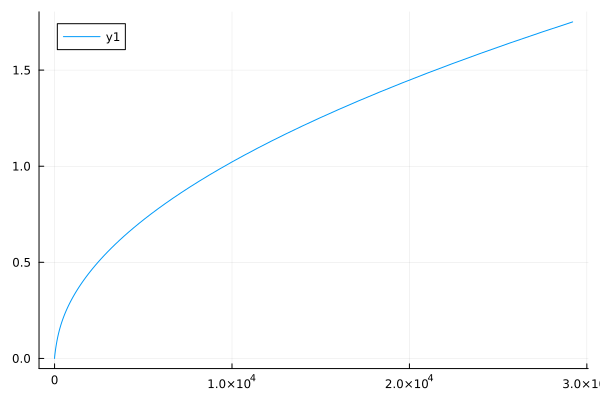

In [62]:
plot(sol.t, sol[3,:])